In [1]:
# Data Mining Assignment 3
# Author: Sheba Nkinz
# From https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html?spm=a2ty_o01.29997173.0.0.11105171YU5pBH
# We’ll use fetch_20newsgroups() to load the data directly from the web. 

# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import chi2, SelectKBest
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
# Load the dataset
categories = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x',
              'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball',
              'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space',
              'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast',
              'talk.politics.misc', 'talk.religion.misc']

# Fetch training and test sets
train_data = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
test_data = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

print("Training set size:", len(train_data.data))
print("Test set size:", len(test_data.data))
print("Number of categories:", len(categories))
print("Categories:", train_data.target_names)

Training set size: 11314
Test set size: 7532
Number of categories: 20
Categories: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


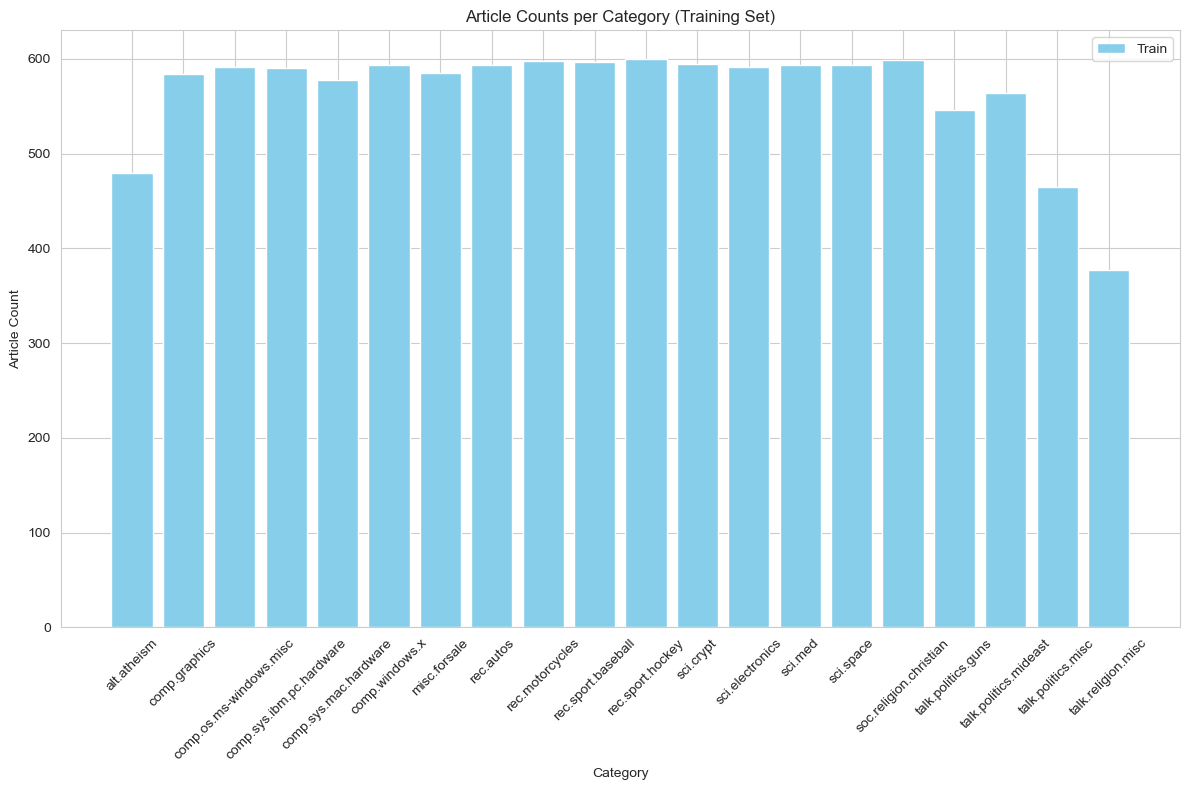

In [3]:
# Count articles per category
train_counts = np.bincount(train_data.target)
test_counts = np.bincount(test_data.target)

df_counts = pd.DataFrame({
    'Category': train_data.target_names,
    'Train_Count': train_counts,
    'Test_Count': test_counts
})

# Bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(df_counts['Category'], df_counts['Train_Count'], color='skyblue', label='Train')
plt.xlabel('Category')
plt.ylabel('Article Count')
plt.title('Article Counts per Category (Training Set)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

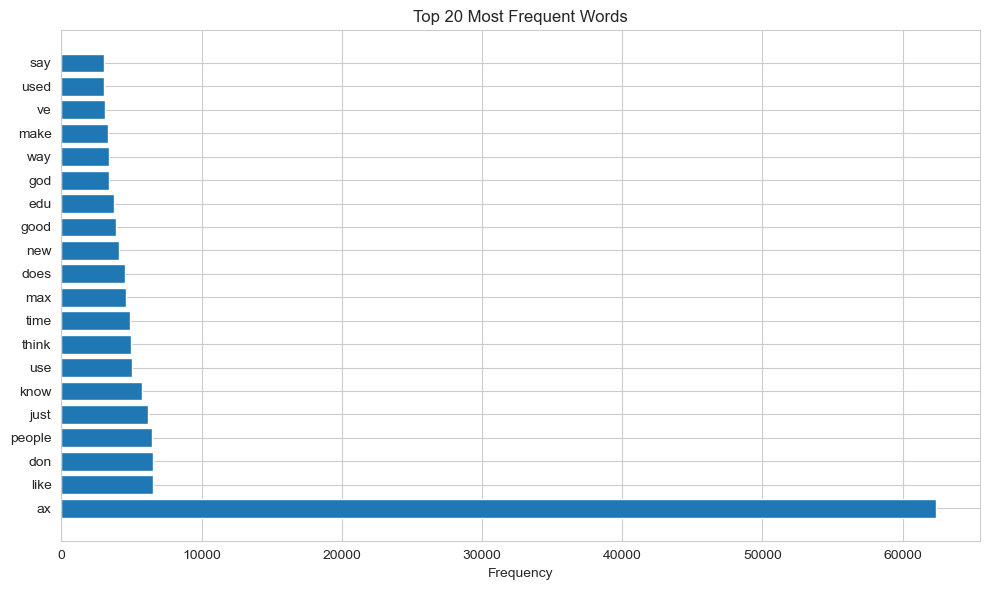

In [6]:
# Combine all texts
all_texts = train_data.data + test_data.data

# Count word frequencies
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
X_count = vectorizer.fit_transform(all_texts)

# Get top 20 most frequent words
word_freq = X_count.sum(axis=0).A.ravel()
top_words = np.argsort(word_freq)[-20:][::-1]
top_word_names = [vectorizer.get_feature_names_out()[i] for i in top_words]

plt.figure(figsize=(10, 6))
plt.barh(top_word_names, word_freq[top_words])
plt.xlabel('Frequency')
plt.title('Top 20 Most Frequent Words')
plt.tight_layout()
plt.show()

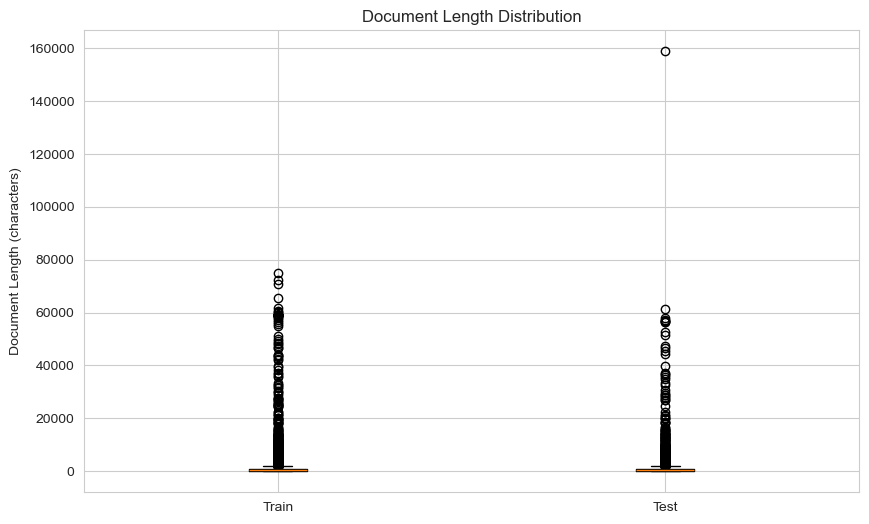

In [7]:
# Document lengths
train_lengths = [len(text) for text in train_data.data]
test_lengths = [len(text) for text in test_data.data]

# Boxplot
plt.figure(figsize=(10, 6))
box_plot = plt.boxplot([train_lengths, test_lengths], labels=['Train', 'Test'])
plt.ylabel('Document Length (characters)')
plt.title('Document Length Distribution')
plt.show()

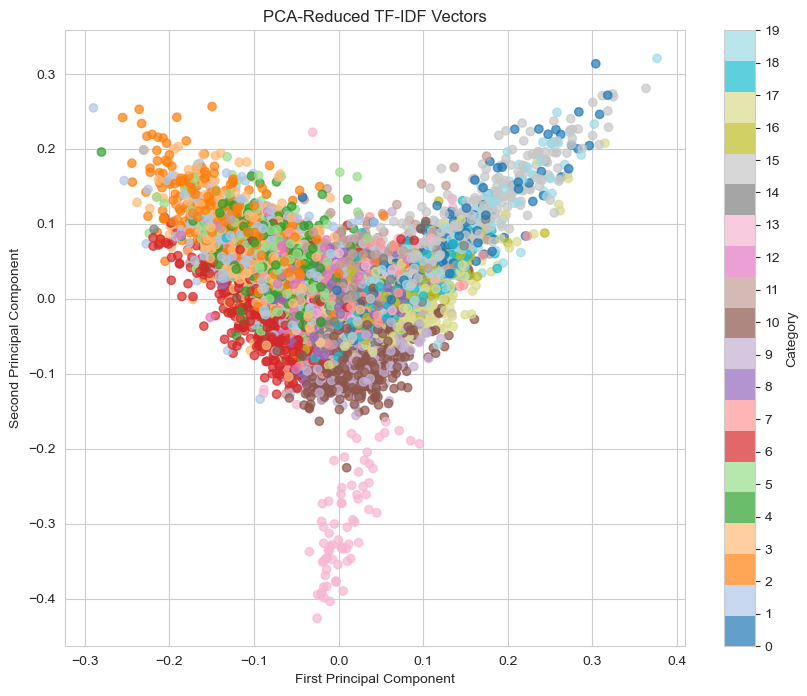

In [8]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data.data)
X_test_tfidf = tfidf_vectorizer.transform(test_data.data)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_tfidf.toarray())

# Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_data.target, cmap='tab20', alpha=0.7)
plt.colorbar(scatter, ticks=range(len(categories)), label='Category')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA-Reduced TF-IDF Vectors')
plt.show()

In [10]:
# Compare unigrams vs bigrams
unigram_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
bigram_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(2, 2), max_features=5000)

X_uni = unigram_vectorizer.fit_transform(train_data.data)
X_bi = bigram_vectorizer.fit_transform(train_data.data)

print("Unigram features:", X_uni.shape[1])
print("Bigram features:", X_bi.shape[1])

Unigram features: 5000
Bigram features: 5000


In [6]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

# Assuming train_data.data contains your text documents
# First, create the TF-IDF representation
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data.data)

# Now reduce vocabulary using Chi-Square
selector = SelectKBest(chi2, k=1000)
X_selected = selector.fit_transform(X_train_tfidf, train_data.target)

print("Original features:", X_train_tfidf.shape[1])
print("Selected features:", X_selected.shape[1])


Original features: 5000
Selected features: 1000


In [11]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X_train_tfidf, train_data.target, test_size=0.2, random_state=42)

# Train SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Train MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=100, random_state=42)
mlp_model.fit(X_train, y_train)

MLPClassifier(max_iter=100, random_state=42)

SVM Accuracy: 0.681, Macro-F1: 0.675
MLP Accuracy: 0.690, Macro-F1: 0.688


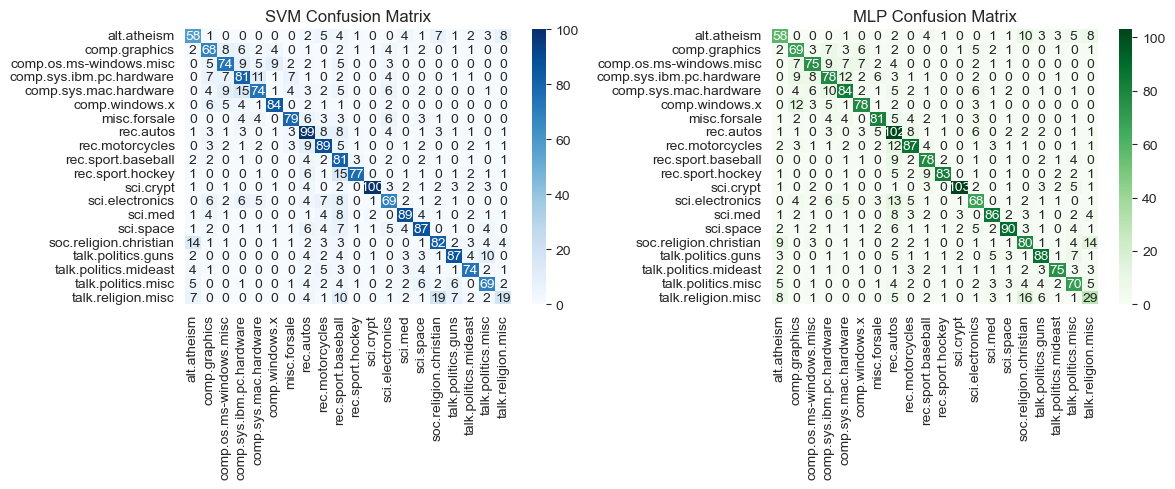

In [13]:
# Predictions
svm_pred = svm_model.predict(X_val)
mlp_pred = mlp_model.predict(X_val)

# Metrics
svm_acc = accuracy_score(y_val, svm_pred)
svm_f1 = f1_score(y_val, svm_pred, average='macro')

mlp_acc = accuracy_score(y_val, mlp_pred)
mlp_f1 = f1_score(y_val, mlp_pred, average='macro')

print(f"SVM Accuracy: {svm_acc:.3f}, Macro-F1: {svm_f1:.3f}")
print(f"MLP Accuracy: {mlp_acc:.3f}, Macro-F1: {mlp_f1:.3f}")

# Confusion Matrix
cm_svm = confusion_matrix(y_val, svm_pred)
cm_mlp = confusion_matrix(y_val, mlp_pred)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.title("SVM Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Greens', xticklabels=categories, yticklabels=categories)
plt.title("MLP Confusion Matrix")

plt.tight_layout()
plt.show()

 Reflection: Interpretability vs High-Dimensional Features

 1. Interpretability vs Dimensionality
- High-dimensional features (like TF-IDF) capture rich patterns but are hard to interpret.
- SVM** is more interpretable (uses support vectors), while MLP is a "black box".
- PCA/t-SNE help visualize high-dimensional data but lose meaning in reduced space.

2. Trade-offs
- Accuracy: MLP often outperforms SVM due to non-linear learning.
- Speed: SVM is faster to train; MLP requires more epochs.
- Scalability: TF-IDF with Chi-Square reduces dimensionality → faster models.

3. Best Practices
- Use feature selection (Chi-Square) to reduce noise.
- Use t-SNE/UMAP for visualization, not modeling.
- Combine ensemble methods (stacking) for better performance.

Conclusion: Balance model complexity with interpretability. Use SVM for transparency, MLP for accuracy, and preprocessing to manage dimensionality.